In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/ppm-theory/PPM Theory.csv
/kaggle/input/intuition-theory-prediction/intuition_and_theory_explanation_prediction.csv


# 0. PPM Thoery-guided 数据集

In [2]:
df = pd.read_csv("/kaggle/input/ppm-theory/PPM Theory.csv")
df.head(2)

,Unnamed: 0.1,Unnamed: 0,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target,Prediction,Explanation,all_Prediction,all_Explanation
0,0,0,0.920,Male,No relevent experience,Full time course,Masters,Other,17,10000+,Public Sector,1,66,0.0,1.0,Although the candidate has 17 years of working...,0.0,"Based on the PushPullMooring theory, I predict..."
1,1,1,0.939,Male,No relevent experience,Part time course,High School,not given us,4,10/49,Pvt Ltd,1,12,0.0,1.0,Although the candidate has 4 years of working ...,1.0,"Based on the PushPullMooring theory, I predict..."


# ***重新做一遍实验***

## 0.1 Baseline

In [12]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# ========== STEP 1: 数据加载与预处理 ==========
# 用你的实际 DataFrame 替代
df = df.copy()  # 假设你的 DataFrame 已经是 df

categorical_cols = ['gender', 'relevent_experience', 'enrolled_university',
                    'education_level', 'major_discipline', 'experience',
                    'company_size', 'company_type','last_new_job']
numerical_cols = ['city_development_index','training_hours']
target_col = 'target'

# 填充缺失值
df[categorical_cols] = df[categorical_cols].fillna("UNKNOWN")
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# ========== STEP 2: Word2Vec Skip-gram ==========
w2v_models = {}
embedding_size = 8  # 小数据建议用小维度

for col in categorical_cols:
    sentences = [[str(x)] for x in df[col].values]
    model = Word2Vec(sentences=sentences, vector_size=embedding_size, window=2, min_count=1, sg=0, epochs=30) # sg 为0时为 CBOW 1时为skip-gram
    w2v_models[col] = model

# 数值特征标准化
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# ========== STEP 3: 构建 BiLSTM 输入序列 ==========
def row_to_sequence(row):
    seq = []
    for col in categorical_cols:
        word = str(row[col])
        vec = w2v_models[col].wv[word]
        seq.append(vec)
    for col in numerical_cols:
        vec = np.full((embedding_size,), row[col])
        seq.append(vec)
    return np.stack(seq)  # shape: (len(categorical_cols + numerical_cols), embedding_size)

X_seq = np.stack([row_to_sequence(row) for _, row in df.iterrows()])
y = df[target_col].values

# ========== STEP 4: 数据划分 ==========
X_train, X_test, y_train, y_test = train_test_split(X_seq, y, test_size=0.3, random_state=42
                                        #            ,stratify=y
                                                   )

# ========== STEP 5: PyTorch Dataset 和 Dataloader ==========
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(SequenceDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(SequenceDataset(X_test, y_test), batch_size=16)

# ========== STEP 6: Bi-LSTM 模型 ==========
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=64, output_dim=2, num_layers=1, dropout=0.1):
        super().__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # 因为是双向，所以乘2
        self.relu = nn.ReLU()

    def forward(self, x):
        # 输入 x 形状: (batch, seq_len, input_dim)
        lstm_out, _ = self.bilstm(x)        # (batch, seq_len, hidden_dim*2)
        x = lstm_out[:, -1, :]              # 取最后时间步的输出
        x = self.relu(x)
        return self.fc(x)                   # (batch, output_dim)


model = BiLSTMClassifier(input_dim=8, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)




# ========== STEP 7: 训练 ==========
for epoch in range(30):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}") # 此处打印的为Training loss 

# ========== STEP 8: 评估 ==========
import torch.nn.functional as F

model.eval()
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch)

        # 获取预测标签（0或1）
        preds = torch.argmax(logits, dim=1)
        y_pred.extend(preds.cpu().numpy())

        # 获取正类的概率值，假设是二分类，正类索引为 1
        probs = F.softmax(logits, dim=1)[:, 1]
        y_score.extend(probs.cpu().numpy())

        y_true.extend(y_batch.cpu().numpy())


from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, roc_auc_score
)

def evaluate(y_true, y_pred, y_score=None):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn + 1e-8)
    pnr = fn / (fn + tp + 1e-8)
    auc = roc_auc_score(y_true, y_score) if y_score is not None else None
    return precision, recall, f1, acc, fpr, pnr, auc

# 示例调用
metrics = evaluate(y_true, y_pred, y_score)
names = ['Precision', 'Recall', 'F1', 'Accuracy', 'FPR', 'PNR', 'AUC']
for n, v in zip(names, metrics):
    print(f"{n}: {v:.4f}" if v is not None else f"{n}: N/A")

Epoch 1, Loss: 6.2428
Epoch 2, Loss: 6.1981
Epoch 3, Loss: 6.1547
Epoch 4, Loss: 6.1151
Epoch 5, Loss: 6.0669
Epoch 6, Loss: 5.9957
Epoch 7, Loss: 5.9373
Epoch 8, Loss: 5.8517
Epoch 9, Loss: 5.7407
Epoch 10, Loss: 5.6344
Epoch 11, Loss: 5.5497
Epoch 12, Loss: 5.4330
Epoch 13, Loss: 5.3167
Epoch 14, Loss: 5.2863
Epoch 15, Loss: 5.2299
Epoch 16, Loss: 5.2176
Epoch 17, Loss: 5.1878
Epoch 18, Loss: 5.1758
Epoch 19, Loss: 5.1104
Epoch 20, Loss: 5.1101
Epoch 21, Loss: 5.1237
Epoch 22, Loss: 5.1438
Epoch 23, Loss: 5.1587
Epoch 24, Loss: 5.0581
Epoch 25, Loss: 5.0963
Epoch 26, Loss: 5.0454
Epoch 27, Loss: 5.0149
Epoch 28, Loss: 5.0535
Epoch 29, Loss: 5.0863
Epoch 30, Loss: 5.0525
Precision: 0.7333
Recall: 0.3793
F1: 0.5000
Accuracy: 0.6333
FPR: 0.1290
PNR: 0.6207
AUC: 0.6385


## 0.2 所有设计在一起

In [13]:
# STEP 0: 引入 BERT 模块和 PCA
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from tqdm import tqdm

# STEP 1: 加载 BERT 模型（一次性加载）
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()  # 不训练

# STEP 2: 获取 Explanation 的 BERT 向量
@torch.no_grad()
def get_bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = bert_model(**inputs)
    # 使用 [CLS] 向量作为整句表示
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: [1, 768]
    return cls_embedding.squeeze().numpy()  # shape: [768,]

# 生成所有 Explanation 的 BERT 向量
explanation_embeddings = np.stack([get_bert_embedding(str(x)) for x in tqdm(df['all_Explanation'])])

# STEP 3: 使用 PCA 降维将 BERT 向量从 768 维降到 8 维
pca = PCA(n_components=8)
explanation_embeddings_8d = pca.fit_transform(explanation_embeddings)  # shape: (200, 8)

# STEP 4: Word2Vec 和数值特征的序列化
def row_to_sequence(row):
    seq = []
    for col in categorical_cols:
        word = str(row[col])
        vec = w2v_models[col].wv[word]
        seq.append(vec)
    for col in numerical_cols:
        vec = np.full((embedding_size,), row[col])
        seq.append(vec)
    return np.stack(seq)  # shape: (len(categorical_cols + numerical_cols), embedding_size)

X_seq_with_exp = []

for i in range(len(df)):
    original_seq = row_to_sequence(df.iloc[i])  # shape: (seq_len, 8)
    exp_vec_8d = explanation_embeddings_8d[i].reshape(1, -1)  # shape: (1, 8)
    full_seq = np.concatenate([original_seq, exp_vec_8d], axis=0)  # shape: (seq_len + 1, 8) # 注意此处是直接进行拼接
    X_seq_with_exp.append(full_seq)

X_seq_with_exp = np.stack(X_seq_with_exp)
y = df[target_col].values

# STEP 5: 划分训练集
X_train, X_test, y_train, y_test = train_test_split(X_seq_with_exp, y, test_size=0.3, random_state=42
                                            #       , stratify=y
                                                   )

# STEP 6: 新的 Dataset 和 Dataloader
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(SequenceDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(SequenceDataset(X_test, y_test), batch_size=16)

# # ========== STEP 7: BiLSTM ==========

import torch.nn as nn

class BiLSTMWithBert(nn.Module):
    def __init__(self, input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2, num_layers=1):
        super().__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.linear_exp = nn.Linear(exp_dim, hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, x):
        x_seq = x[:, :-1, :]   # (batch, seq_len, input_dim)
        x_exp = x[:, -1, :]    # (batch, exp_dim)

        # BiLSTM outputs
        lstm_out, _ = self.bilstm(x_seq)      # (batch, seq_len, hidden_dim*2)
        lstm_feat = lstm_out.mean(dim=1)      # Mean pooling over time

        exp_feat = self.linear_exp(x_exp)     # (batch, hidden_dim*2)

        combined = torch.cat([lstm_feat, exp_feat], dim=1)  # (batch, hidden_dim*4)
        return self.fc(combined)

model = BiLSTMWithBert(input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

# 定义对比损失regularizer 
def info_nce_loss(features, labels, temperature=0.5):
    """
    features: tensor of shape (batch_size, embed_dim)
    labels: tensor of shape (batch_size,) with class labels
    """
    # Normalize features
    features = F.normalize(features, dim=1)  # cosine sim
    similarity_matrix = torch.matmul(features, features.T)  # (batch, batch)

    # Build labels mask (positive pairs: same label)
    labels = labels.contiguous().view(-1, 1)
    mask = torch.eq(labels, labels.T).float().to(features.device)  # (batch, batch)

    # Avoid self-similarity
    self_mask = torch.eye(mask.shape[0], device=features.device)
    mask = mask - self_mask  # 1 for positive pairs only, 0 elsewhere

    # Scale similarity
    logits = similarity_matrix / temperature

    # For numerical stability
    logits_max, _ = torch.max(logits, dim=1, keepdim=True)
    logits = logits - logits_max.detach()

    exp_logits = torch.exp(logits) * (1 - self_mask)
    log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-8)

    # Compute mean of log-likelihood over positive
    mean_log_prob_pos = (mask * log_prob).sum(dim=1) / (mask.sum(dim=1) + 1e-8)

    loss = -mean_log_prob_pos.mean()
    return loss

import torch.nn.functional as F

def cosine_similarity_matrix(features):
    """计算归一化后的余弦相似度矩阵"""
    features = F.normalize(features, dim=1)
    return torch.matmul(features, features.T)

for epoch in range(40):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(X_batch)

        # 原始分类损失
        loss_cls = criterion(logits, y_batch)

        # 中间表示提取
        x_seq = X_batch[:, :-1, :]
        x_exp = X_batch[:, -1, :]

        # 原始序列平均池化作为 baseline 特征
        original_feat = x_seq.mean(dim=1)  # (batch, input_dim)

        # 模型的中间输出
        lstm_out, _ = model.bilstm(x_seq)
        lstm_feat = lstm_out.mean(dim=1)  # (batch, hidden_dim*2)
        exp_feat = model.linear_exp(x_exp)  # (batch, hidden_dim*2)
        fused_feat = torch.cat([lstm_feat, exp_feat], dim=1)  # (batch, hidden_dim*4)

        # 对比损失 (InfoNCE)
        loss_contrast = info_nce_loss(fused_feat, y_batch)

        # 一致性惩罚项
        sim_orig = cosine_similarity_matrix(original_feat)
        sim_fused = cosine_similarity_matrix(fused_feat)
        # 只保留非对角线项（mask掉自己和自己）
        batch_size = sim_orig.shape[0]
        mask = ~torch.eye(batch_size, dtype=bool, device=sim_orig.device)
        loss_consistency = torch.abs(sim_orig - sim_fused)[mask].mean()

        # 总损失
        alpha = 0.05  # 对比损失系数 0.05
        beta = 0.05    # 一致性损失系数，可调节 0.1
        loss = loss_cls + alpha * loss_contrast + beta * loss_consistency
        # alpha=0.01, beta=0.0 => Avg F1: 0.6486 交叉验证寻求最有组合

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


# STEP 9: 评估
import torch.nn.functional as F

model.eval()
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch)

        # 获取预测标签（0或1）
        preds = torch.argmax(logits, dim=1)
        y_pred.extend(preds.cpu().numpy())

        # 获取正类的概率值，假设是二分类，正类索引为 1
        probs = F.softmax(logits, dim=1)[:, 1]
        y_score.extend(probs.cpu().numpy())

        y_true.extend(y_batch.cpu().numpy())


from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, roc_auc_score
)

def evaluate(y_true, y_pred, y_score=None):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn + 1e-8)
    pnr = fn / (fn + tp + 1e-8)
    auc = roc_auc_score(y_true, y_score) if y_score is not None else None
    return precision, recall, f1, acc, fpr, pnr, auc

# 示例调用
metrics = evaluate(y_true, y_pred, y_score)
names = ['Precision', 'Recall', 'F1', 'Accuracy', 'FPR', 'PNR', 'AUC']
for n, v in zip(names, metrics):
    print(f"{n}: {v:.4f}" if v is not None else f"{n}: N/A")

# 训练直至收敛

100%|██████████| 200/200 [00:29<00:00,  6.70it/s]


Epoch 1, Loss: 7.7421
Epoch 2, Loss: 7.5244
Epoch 3, Loss: 7.3765
Epoch 4, Loss: 7.2548
Epoch 5, Loss: 7.2118
Epoch 6, Loss: 7.1145
Epoch 7, Loss: 7.0518
Epoch 8, Loss: 7.0464
Epoch 9, Loss: 6.9695
Epoch 10, Loss: 6.9279
Epoch 11, Loss: 6.8296
Epoch 12, Loss: 6.7721
Epoch 13, Loss: 6.7114
Epoch 14, Loss: 6.6480
Epoch 15, Loss: 6.6091
Epoch 16, Loss: 6.5524
Epoch 17, Loss: 6.5497
Epoch 18, Loss: 6.5149
Epoch 19, Loss: 6.5123
Epoch 20, Loss: 6.5024
Epoch 21, Loss: 6.4837
Epoch 22, Loss: 6.4190
Epoch 23, Loss: 6.4359
Epoch 24, Loss: 6.4170
Epoch 25, Loss: 6.4175
Epoch 26, Loss: 6.3762
Epoch 27, Loss: 6.3263
Epoch 28, Loss: 6.4221
Epoch 29, Loss: 6.3211
Epoch 30, Loss: 6.3387
Epoch 31, Loss: 6.3133
Epoch 32, Loss: 6.4599
Epoch 33, Loss: 6.3118
Epoch 34, Loss: 6.3600
Epoch 35, Loss: 6.3852
Epoch 36, Loss: 6.3185
Epoch 37, Loss: 6.3311
Epoch 38, Loss: 6.3373
Epoch 39, Loss: 6.3644
Epoch 40, Loss: 6.3066
Precision: 0.7407
Recall: 0.6897
F1: 0.7143
Accuracy: 0.7333
FPR: 0.2258
PNR: 0.3103
AUC:

# 每次训练，测试数据不同都需要不同的调整参数（炼丹）

## Candidate-Enhancer w/o cross-attention
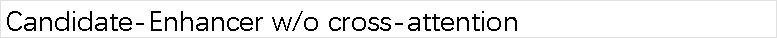
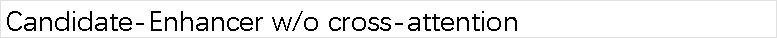
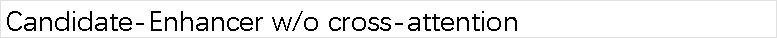
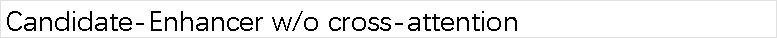

In [6]:
# STEP 0: 引入 BERT 模块和 PCA
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from tqdm import tqdm

# STEP 1: 加载 BERT 模型（一次性加载）
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()  # 不训练

# STEP 2: 获取 Explanation 的 BERT 向量
@torch.no_grad()
def get_bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = bert_model(**inputs)
    # 使用 [CLS] 向量作为整句表示
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: [1, 768]
    return cls_embedding.squeeze().numpy()  # shape: [768,]

# 生成所有 Explanation 的 BERT 向量
explanation_embeddings = np.stack([get_bert_embedding(str(x)) for x in tqdm(df['all_Explanation'])])

# STEP 3: 使用 PCA 降维将 BERT 向量从 768 维降到 8 维
pca = PCA(n_components=8)
explanation_embeddings_8d = pca.fit_transform(explanation_embeddings)  # shape: (200, 8)

# STEP 4: Word2Vec 和数值特征的序列化
def row_to_sequence(row):
    seq = []
    for col in categorical_cols:
        word = str(row[col])
        vec = w2v_models[col].wv[word]
        seq.append(vec)
    for col in numerical_cols:
        vec = np.full((embedding_size,), row[col])
        seq.append(vec)
    return np.stack(seq)  # shape: (len(categorical_cols + numerical_cols), embedding_size)

# X_seq_with_exp = []

# for i in range(len(df)):
#     original_seq = row_to_sequence(df.iloc[i])  # shape: (seq_len, 8)
#     exp_vec_8d = explanation_embeddings_8d[i].reshape(1, -1)  # shape: (1, 8)
#     full_seq = np.concatenate([original_seq, exp_vec_8d], axis=0)  # shape: (seq_len + 1, 8) # 注意此处是直接进行拼接
#     X_seq_with_exp.append(full_seq)

# X_seq_with_exp = np.stack(X_seq_with_exp)
# y = df[target_col].values

# 选项2 使用 Cross-attention 融合
import torch
import torch.nn as nn

# 定义 Cross-Attention 模块
class CrossAttentionFusion(nn.Module):
    def __init__(self, embed_dim=8, num_heads=1):
        super(CrossAttentionFusion, self).__init__()
        self.cross_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, query_vec, context_seq):
        # query_vec: (B, 1, E)
        # context_seq: (B, L, E)
        attn_output, _ = self.cross_attn(query_vec, context_seq, context_seq)
#        attn_output, _ = self.cross_attn(context_seq, query_vec, query_vec) 效果不好
        fused = self.norm(query_vec + attn_output)
        return fused  # shape: (B, 1, E)

# 初始化模块（可以放在外部）
cross_attention = CrossAttentionFusion(embed_dim=8, num_heads=1)

# 融合序列和解释向量
X_seq_with_exp = []

for i in range(len(df)):
    row = df.iloc[i]
    
    original_seq = row_to_sequence(row)  # shape: (seq_len, 8)
    exp_vec_8d = explanation_embeddings_8d[i].reshape(1, 8)  # shape: (1, 8)

    # 转换为 tensor
    context_seq = torch.tensor(original_seq, dtype=torch.float32).unsqueeze(0)  # shape: (1, seq_len, 8)
    query_vec = torch.tensor(exp_vec_8d, dtype=torch.float32).unsqueeze(0)      # shape: (1, 1, 8)

    # 运行 cross-attention
    fused_vec = cross_attention(query_vec, context_seq)  # shape: (1, 1, 8)
    fused_vec_np = fused_vec.squeeze(0).detach().numpy()  # shape: (1, 8)

    # 选择如何使用融合后的向量：拼接 or 替换
    full_seq = np.concatenate([original_seq, fused_vec_np], axis=0)  # shape: (seq_len + 1, 8)

    X_seq_with_exp.append(full_seq)

X_seq_with_exp = np.stack(X_seq_with_exp)  # shape: (num_samples, seq_len + 1, 8)
y = df[target_col].values

# STEP 5: 划分训练集
X_train, X_test, y_train, y_test = train_test_split(X_seq_with_exp, y, test_size=0.3, random_state=42
                                            #       , stratify=y
                                                   )

# STEP 6: 新的 Dataset 和 Dataloader
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(SequenceDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(SequenceDataset(X_test, y_test), batch_size=16)

# # ========== STEP 7: BiLSTM ==========

import torch.nn as nn

class BiLSTMWithBert(nn.Module):
    def __init__(self, input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2, num_layers=1):
        super().__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.linear_exp = nn.Linear(exp_dim, hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, x):
        x_seq = x[:, :-1, :]   # (batch, seq_len, input_dim)
        x_exp = x[:, -1, :]    # (batch, exp_dim)

        # BiLSTM outputs
        lstm_out, _ = self.bilstm(x_seq)      # (batch, seq_len, hidden_dim*2)
        lstm_feat = lstm_out.mean(dim=1)      # Mean pooling over time

        exp_feat = self.linear_exp(x_exp)     # (batch, hidden_dim*2)

        combined = torch.cat([lstm_feat, exp_feat], dim=1)  # (batch, hidden_dim*4)
        return self.fc(combined)

model = BiLSTMWithBert(input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

# 定义对比损失regularizer 
def info_nce_loss(features, labels, temperature=0.5):
    """
    features: tensor of shape (batch_size, embed_dim)
    labels: tensor of shape (batch_size,) with class labels
    """
    # Normalize features
    features = F.normalize(features, dim=1)  # cosine sim
    similarity_matrix = torch.matmul(features, features.T)  # (batch, batch)

    # Build labels mask (positive pairs: same label)
    labels = labels.contiguous().view(-1, 1)
    mask = torch.eq(labels, labels.T).float().to(features.device)  # (batch, batch)

    # Avoid self-similarity
    self_mask = torch.eye(mask.shape[0], device=features.device)
    mask = mask - self_mask  # 1 for positive pairs only, 0 elsewhere

    # Scale similarity
    logits = similarity_matrix / temperature

    # For numerical stability
    logits_max, _ = torch.max(logits, dim=1, keepdim=True)
    logits = logits - logits_max.detach()

    exp_logits = torch.exp(logits) * (1 - self_mask)
    log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-8)

    # Compute mean of log-likelihood over positive
    mean_log_prob_pos = (mask * log_prob).sum(dim=1) / (mask.sum(dim=1) + 1e-8)

    loss = -mean_log_prob_pos.mean()
    return loss

import torch.nn.functional as F

def cosine_similarity_matrix(features):
    """计算归一化后的余弦相似度矩阵"""
    features = F.normalize(features, dim=1)
    return torch.matmul(features, features.T)

for epoch in range(30):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(X_batch)

        # 原始分类损失
        loss_cls = criterion(logits, y_batch)

        # 中间表示提取
        x_seq = X_batch[:, :-1, :]
        x_exp = X_batch[:, -1, :]

        # 原始序列平均池化作为 baseline 特征
        original_feat = x_seq.mean(dim=1)  # (batch, input_dim)

        # 模型的中间输出
        lstm_out, _ = model.bilstm(x_seq)
        lstm_feat = lstm_out.mean(dim=1)  # (batch, hidden_dim*2)
        exp_feat = model.linear_exp(x_exp)  # (batch, hidden_dim*2)
        fused_feat = torch.cat([lstm_feat, exp_feat], dim=1)  # (batch, hidden_dim*4)

        # 对比损失 (InfoNCE)
        loss_contrast = info_nce_loss(fused_feat, y_batch)

        # 一致性惩罚项
        sim_orig = cosine_similarity_matrix(original_feat)
        sim_fused = cosine_similarity_matrix(fused_feat)
        # 只保留非对角线项（mask掉自己和自己）
        batch_size = sim_orig.shape[0]
        mask = ~torch.eye(batch_size, dtype=bool, device=sim_orig.device)
        loss_consistency = torch.abs(sim_orig - sim_fused)[mask].mean()

        # 总损失
        alpha = 0.05  # 对比损失系数 0.05
        beta = 0.05    # 一致性损失系数，可调节 0.1
        loss = loss_cls + alpha * loss_contrast + beta * loss_consistency
        # alpha=0.01, beta=0.0 => Avg F1: 0.6486 交叉验证寻求最有组合

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


# STEP 9: 评估
import torch.nn.functional as F

model.eval()
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch)

        # 获取预测标签（0或1）
        preds = torch.argmax(logits, dim=1)
        y_pred.extend(preds.cpu().numpy())

        # 获取正类的概率值，假设是二分类，正类索引为 1
        probs = F.softmax(logits, dim=1)[:, 1]
        y_score.extend(probs.cpu().numpy())

        y_true.extend(y_batch.cpu().numpy())


from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, roc_auc_score
)

def evaluate(y_true, y_pred, y_score=None):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn + 1e-8)
    pnr = fn / (fn + tp + 1e-8)
    auc = roc_auc_score(y_true, y_score) if y_score is not None else None
    return precision, recall, f1, acc, fpr, pnr, auc

# 示例调用
metrics = evaluate(y_true, y_pred, y_score)
names = ['Precision', 'Recall', 'F1', 'Accuracy', 'FPR', 'PNR', 'AUC']
for n, v in zip(names, metrics):
    print(f"{n}: {v:.4f}" if v is not None else f"{n}: N/A")

# 训练直至收敛

100%|██████████| 200/200 [00:29<00:00,  6.72it/s]


Epoch 1, Loss: 8.5799
Epoch 2, Loss: 8.2054
Epoch 3, Loss: 7.9707
Epoch 4, Loss: 7.7622
Epoch 5, Loss: 7.6103
Epoch 6, Loss: 7.4538
Epoch 7, Loss: 7.3793
Epoch 8, Loss: 7.2558
Epoch 9, Loss: 7.2011
Epoch 10, Loss: 7.1640
Epoch 11, Loss: 7.0095
Epoch 12, Loss: 7.0241
Epoch 13, Loss: 6.9014
Epoch 14, Loss: 6.7307
Epoch 15, Loss: 6.7287
Epoch 16, Loss: 6.5954
Epoch 17, Loss: 6.5172
Epoch 18, Loss: 6.6050
Epoch 19, Loss: 6.5041
Epoch 20, Loss: 6.4779
Epoch 21, Loss: 6.5760
Epoch 22, Loss: 6.4663
Epoch 23, Loss: 6.4324
Epoch 24, Loss: 6.4891
Epoch 25, Loss: 6.4668
Epoch 26, Loss: 6.4576
Epoch 27, Loss: 6.4440
Epoch 28, Loss: 6.4087
Epoch 29, Loss: 6.4341
Epoch 30, Loss: 6.3993
Precision: 0.6923
Recall: 0.6207
F1: 0.6545
Accuracy: 0.6833
FPR: 0.2581
PNR: 0.3793
AUC: 0.7419


# 1. Baseline 

In [6]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

# ========== STEP 1: 数据加载与预处理 ==========
# 用你的实际 DataFrame 替代
df = df.copy()  # 假设你的 DataFrame 已经是 df

categorical_cols = ['gender', 'relevent_experience', 'enrolled_university',
                    'education_level', 'major_discipline', 'experience',
                    'company_size', 'company_type','last_new_job']
numerical_cols = ['city_development_index','training_hours']
target_col = 'target'

# 填充缺失值
df[categorical_cols] = df[categorical_cols].fillna("UNKNOWN")
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# ========== STEP 2: Word2Vec Skip-gram ==========
w2v_models = {}
embedding_size = 8  # 小数据建议用小维度

for col in categorical_cols:
    sentences = [[str(x)] for x in df[col].values]
    model = Word2Vec(sentences=sentences, vector_size=embedding_size, window=2, min_count=1, sg=0, epochs=30) # sg 为0时为 CBOW 1时为skip-gram
    w2v_models[col] = model

# 数值特征标准化
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# ========== STEP 3: 构建 BiLSTM 输入序列 ==========
def row_to_sequence(row):
    seq = []
    for col in categorical_cols:
        word = str(row[col])
        vec = w2v_models[col].wv[word]
        seq.append(vec)
    for col in numerical_cols:
        vec = np.full((embedding_size,), row[col])
        seq.append(vec)
    return np.stack(seq)  # shape: (len(categorical_cols + numerical_cols), embedding_size)

X_seq = np.stack([row_to_sequence(row) for _, row in df.iterrows()])
y = df[target_col].values

# ========== STEP 4: 数据划分 ==========
X_train, X_test, y_train, y_test = train_test_split(X_seq, y, test_size=0.3, random_state=42
                                        #            ,stratify=y
                                                   )

# ========== STEP 5: PyTorch Dataset 和 Dataloader ==========
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(SequenceDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(SequenceDataset(X_test, y_test), batch_size=16)

# ========== STEP 6: Bi-LSTM 模型 ==========
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=64, output_dim=2, num_layers=1, dropout=0.1):
        super().__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # 因为是双向，所以乘2
        self.relu = nn.ReLU()

    def forward(self, x):
        # 输入 x 形状: (batch, seq_len, input_dim)
        lstm_out, _ = self.bilstm(x)        # (batch, seq_len, hidden_dim*2)
        x = lstm_out[:, -1, :]              # 取最后时间步的输出
        x = self.relu(x)
        return self.fc(x)                   # (batch, output_dim)


model = BiLSTMClassifier(input_dim=8, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)




# ========== STEP 7: 训练 ==========
for epoch in range(30):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}") # 此处打印的为Training loss 

# ========== STEP 8: 评估 ==========
import torch.nn.functional as F

model.eval()
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch)

        # 获取预测标签（0或1）
        preds = torch.argmax(logits, dim=1)
        y_pred.extend(preds.cpu().numpy())

        # 获取正类的概率值，假设是二分类，正类索引为 1
        probs = F.softmax(logits, dim=1)[:, 1]
        y_score.extend(probs.cpu().numpy())

        y_true.extend(y_batch.cpu().numpy())


from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, roc_auc_score
)

def evaluate(y_true, y_pred, y_score=None):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn + 1e-8)
    pnr = fn / (fn + tp + 1e-8)
    auc = roc_auc_score(y_true, y_score) if y_score is not None else None
    return precision, recall, f1, acc, fpr, pnr, auc

# 示例调用
metrics = evaluate(y_true, y_pred, y_score)
names = ['Precision', 'Recall', 'F1', 'Accuracy', 'FPR', 'PNR', 'AUC']
for n, v in zip(names, metrics):
    print(f"{n}: {v:.4f}" if v is not None else f"{n}: N/A")

Epoch 1, Loss: 6.2368
Epoch 2, Loss: 6.1730
Epoch 3, Loss: 6.1131
Epoch 4, Loss: 6.0579
Epoch 5, Loss: 5.9595
Epoch 6, Loss: 5.8975
Epoch 7, Loss: 5.7862
Epoch 8, Loss: 5.6546
Epoch 9, Loss: 5.5637
Epoch 10, Loss: 5.4869
Epoch 11, Loss: 5.3601
Epoch 12, Loss: 5.2809
Epoch 13, Loss: 5.1856
Epoch 14, Loss: 5.1889
Epoch 15, Loss: 5.1639
Epoch 16, Loss: 5.1060
Epoch 17, Loss: 5.1419
Epoch 18, Loss: 5.1356
Epoch 19, Loss: 5.1116
Epoch 20, Loss: 5.0973
Epoch 21, Loss: 5.0917
Epoch 22, Loss: 5.0466
Epoch 23, Loss: 5.0821
Epoch 24, Loss: 5.0554
Epoch 25, Loss: 5.1115
Epoch 26, Loss: 5.1605
Epoch 27, Loss: 5.0819
Epoch 28, Loss: 5.1336
Epoch 29, Loss: 5.0309
Epoch 30, Loss: 5.0089
Precision: 0.7500
Recall: 0.4138
F1: 0.5333
Accuracy: 0.6500
FPR: 0.1290
PNR: 0.5862
AUC: 0.6429


# 2. LLM-enhanced

In [7]:
# STEP 0: 引入 BERT 模块和 PCA
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from tqdm import tqdm

# STEP 1: 加载 BERT 模型（一次性加载）
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()  # 不训练

# STEP 2: 获取 Explanation 的 BERT 向量
@torch.no_grad()
def get_bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = bert_model(**inputs)
    # 使用 [CLS] 向量作为整句表示
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: [1, 768]
    return cls_embedding.squeeze().numpy()  # shape: [768,]

# 生成所有 Explanation 的 BERT 向量
explanation_embeddings = np.stack([get_bert_embedding(str(x)) for x in tqdm(df['Explanation'])])

# STEP 3: 使用 PCA 降维将 BERT 向量从 768 维降到 8 维
pca = PCA(n_components=8)
explanation_embeddings_8d = pca.fit_transform(explanation_embeddings)  # shape: (200, 8)

# STEP 4: Word2Vec 和数值特征的序列化
def row_to_sequence(row):
    seq = []
    for col in categorical_cols:
        word = str(row[col])
        vec = w2v_models[col].wv[word]
        seq.append(vec)
    for col in numerical_cols:
        vec = np.full((embedding_size,), row[col])
        seq.append(vec)
    return np.stack(seq)  # shape: (len(categorical_cols + numerical_cols), embedding_size)

X_seq_with_exp = []

for i in range(len(df)):
    original_seq = row_to_sequence(df.iloc[i])  # shape: (seq_len, 8)
    exp_vec_8d = explanation_embeddings_8d[i].reshape(1, -1)  # shape: (1, 8)
    full_seq = np.concatenate([original_seq, exp_vec_8d], axis=0)  # shape: (seq_len + 1, 8) # 注意此处是直接进行拼接
    X_seq_with_exp.append(full_seq)

X_seq_with_exp = np.stack(X_seq_with_exp)
y = df[target_col].values

# STEP 5: 划分训练集
X_train, X_test, y_train, y_test = train_test_split(X_seq_with_exp, y, test_size=0.3, random_state=42
                                            #       , stratify=y
                                                   )

# STEP 6: 新的 Dataset 和 Dataloader
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(SequenceDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(SequenceDataset(X_test, y_test), batch_size=16)

# # ========== STEP 7: CNN ==========
# class CNNWithBert(nn.Module):
#     def __init__(self, input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2, kernel_size=3):
#         super().__init__()
#         self.conv1d = nn.Conv1d(in_channels=input_dim, out_channels=hidden_dim, kernel_size=kernel_size, padding=1)
#         self.pool = nn.AdaptiveMaxPool1d(1)  # 全局最大池化（获得 seq 表示）
#         self.linear_exp = nn.Linear(exp_dim, hidden_dim)
#         self.fc = nn.Linear(hidden_dim * 2, output_dim)

#     def forward(self, x):
#         x_cnn = x[:, :-1, :]     # shape: (batch, seq_len, input_dim)
#         x_exp = x[:, -1, :]      # shape: (batch, exp_dim)

#         # Conv1d expects (batch, channels=input_dim, seq_len)
#         x_cnn = x_cnn.permute(0, 2, 1)     # (batch, input_dim, seq_len)
#         cnn_feat = self.conv1d(x_cnn)      # (batch, hidden_dim, seq_len)
#         cnn_feat = self.pool(cnn_feat)     # (batch, hidden_dim, 1)
#         cnn_feat = cnn_feat.squeeze(-1)    # (batch, hidden_dim)

#         exp_feat = self.linear_exp(x_exp)  # (batch, hidden_dim)

#         out = torch.cat([cnn_feat, exp_feat], dim=1)  # (batch, hidden_dim * 2)
#         return self.fc(out)

# # 创建模型、损失函数和优化器
# model = CNNWithBert(input_dim=8, exp_dim=8)

# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

import torch.nn as nn

class BiLSTMWithBert(nn.Module):
    def __init__(self, input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2, num_layers=1):
        super().__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.linear_exp = nn.Linear(exp_dim, hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, x):
        x_seq = x[:, :-1, :]   # (batch, seq_len, input_dim)
        x_exp = x[:, -1, :]    # (batch, exp_dim)

        # BiLSTM outputs
        lstm_out, _ = self.bilstm(x_seq)      # (batch, seq_len, hidden_dim*2)
        lstm_feat = lstm_out.mean(dim=1)      # Mean pooling over time

        exp_feat = self.linear_exp(x_exp)     # (batch, hidden_dim*2)

        combined = torch.cat([lstm_feat, exp_feat], dim=1)  # (batch, hidden_dim*4)
        return self.fc(combined)

model = BiLSTMWithBert(input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)


# STEP 8: 训练
for epoch in range(30):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# STEP 9: 评估
import torch.nn.functional as F

model.eval()
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch)

        # 获取预测标签（0或1）
        preds = torch.argmax(logits, dim=1)
        y_pred.extend(preds.cpu().numpy())

        # 获取正类的概率值，假设是二分类，正类索引为 1
        probs = F.softmax(logits, dim=1)[:, 1]
        y_score.extend(probs.cpu().numpy())

        y_true.extend(y_batch.cpu().numpy())


from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, roc_auc_score
)

def evaluate(y_true, y_pred, y_score=None):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn + 1e-8)
    pnr = fn / (fn + tp + 1e-8)
    auc = roc_auc_score(y_true, y_score) if y_score is not None else None
    return precision, recall, f1, acc, fpr, pnr, auc

# 示例调用
metrics = evaluate(y_true, y_pred, y_score)
names = ['Precision', 'Recall', 'F1', 'Accuracy', 'FPR', 'PNR', 'AUC']
for n, v in zip(names, metrics):
    print(f"{n}: {v:.4f}" if v is not None else f"{n}: N/A")

# 训练直至收敛

100%|██████████| 200/200 [00:27<00:00,  7.39it/s]


Epoch 1, Loss: 6.3723
Epoch 2, Loss: 6.1931
Epoch 3, Loss: 6.1062
Epoch 4, Loss: 6.0105
Epoch 5, Loss: 5.9272
Epoch 6, Loss: 5.8737
Epoch 7, Loss: 5.8073
Epoch 8, Loss: 5.7663
Epoch 9, Loss: 5.7127
Epoch 10, Loss: 5.6629
Epoch 11, Loss: 5.6194
Epoch 12, Loss: 5.5539
Epoch 13, Loss: 5.4850
Epoch 14, Loss: 5.4197
Epoch 15, Loss: 5.2894
Epoch 16, Loss: 5.1900
Epoch 17, Loss: 5.1722
Epoch 18, Loss: 5.0582
Epoch 19, Loss: 5.0024
Epoch 20, Loss: 5.0399
Epoch 21, Loss: 5.0726
Epoch 22, Loss: 5.0131
Epoch 23, Loss: 5.0537
Epoch 24, Loss: 4.9804
Epoch 25, Loss: 4.9902
Epoch 26, Loss: 5.0122
Epoch 27, Loss: 5.0305
Epoch 28, Loss: 4.9951
Epoch 29, Loss: 5.0436
Epoch 30, Loss: 4.9920
Precision: 0.7143
Recall: 0.5172
F1: 0.6000
Accuracy: 0.6667
FPR: 0.1935
PNR: 0.4828
AUC: 0.7152


# 3. Theory-LLM

In [8]:
# STEP 0: 引入 BERT 模块和 PCA
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from tqdm import tqdm

# STEP 1: 加载 BERT 模型（一次性加载）
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()  # 不训练

# STEP 2: 获取 Explanation 的 BERT 向量
@torch.no_grad()
def get_bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = bert_model(**inputs)
    # 使用 [CLS] 向量作为整句表示
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: [1, 768]
    return cls_embedding.squeeze().numpy()  # shape: [768,]

# 生成所有 Explanation 的 BERT 向量
explanation_embeddings = np.stack([get_bert_embedding(str(x)) for x in tqdm(df['all_Explanation'])])

# STEP 3: 使用 PCA 降维将 BERT 向量从 768 维降到 8 维
pca = PCA(n_components=8)
explanation_embeddings_8d = pca.fit_transform(explanation_embeddings)  # shape: (200, 8)

# STEP 4: Word2Vec 和数值特征的序列化
def row_to_sequence(row):
    seq = []
    for col in categorical_cols:
        word = str(row[col])
        vec = w2v_models[col].wv[word]
        seq.append(vec)
    for col in numerical_cols:
        vec = np.full((embedding_size,), row[col])
        seq.append(vec)
    return np.stack(seq)  # shape: (len(categorical_cols + numerical_cols), embedding_size)

X_seq_with_exp = []

for i in range(len(df)):
    original_seq = row_to_sequence(df.iloc[i])  # shape: (seq_len, 8)
    exp_vec_8d = explanation_embeddings_8d[i].reshape(1, -1)  # shape: (1, 8)
    full_seq = np.concatenate([original_seq, exp_vec_8d], axis=0)  # shape: (seq_len + 1, 8) # 注意此处是直接进行拼接
    X_seq_with_exp.append(full_seq)

X_seq_with_exp = np.stack(X_seq_with_exp)
y = df[target_col].values

# STEP 5: 划分训练集
X_train, X_test, y_train, y_test = train_test_split(X_seq_with_exp, y, test_size=0.3, random_state=42
                                            #       , stratify=y
                                                   )

# STEP 6: 新的 Dataset 和 Dataloader
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(SequenceDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(SequenceDataset(X_test, y_test), batch_size=16)

# # ========== STEP 7: BiLSTM ==========

import torch.nn as nn

class BiLSTMWithBert(nn.Module):
    def __init__(self, input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2, num_layers=1):
        super().__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.linear_exp = nn.Linear(exp_dim, hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, x):
        x_seq = x[:, :-1, :]   # (batch, seq_len, input_dim)
        x_exp = x[:, -1, :]    # (batch, exp_dim)

        # BiLSTM outputs
        lstm_out, _ = self.bilstm(x_seq)      # (batch, seq_len, hidden_dim*2)
        lstm_feat = lstm_out.mean(dim=1)      # Mean pooling over time

        exp_feat = self.linear_exp(x_exp)     # (batch, hidden_dim*2)

        combined = torch.cat([lstm_feat, exp_feat], dim=1)  # (batch, hidden_dim*4)
        return self.fc(combined)

model = BiLSTMWithBert(input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)


# STEP 8: 训练
for epoch in range(30):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# STEP 9: 评估
import torch.nn.functional as F

model.eval()
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch)

        # 获取预测标签（0或1）
        preds = torch.argmax(logits, dim=1)
        y_pred.extend(preds.cpu().numpy())

        # 获取正类的概率值，假设是二分类，正类索引为 1
        probs = F.softmax(logits, dim=1)[:, 1]
        y_score.extend(probs.cpu().numpy())

        y_true.extend(y_batch.cpu().numpy())


from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, roc_auc_score
)

def evaluate(y_true, y_pred, y_score=None):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn + 1e-8)
    pnr = fn / (fn + tp + 1e-8)
    auc = roc_auc_score(y_true, y_score) if y_score is not None else None
    return precision, recall, f1, acc, fpr, pnr, auc

# 示例调用
metrics = evaluate(y_true, y_pred, y_score)
names = ['Precision', 'Recall', 'F1', 'Accuracy', 'FPR', 'PNR', 'AUC']
for n, v in zip(names, metrics):
    print(f"{n}: {v:.4f}" if v is not None else f"{n}: N/A")

# 训练直至收敛

100%|██████████| 200/200 [00:28<00:00,  7.12it/s]


Epoch 1, Loss: 6.4427
Epoch 2, Loss: 6.1730
Epoch 3, Loss: 5.9647
Epoch 4, Loss: 5.8379
Epoch 5, Loss: 5.7319
Epoch 6, Loss: 5.6140
Epoch 7, Loss: 5.5968
Epoch 8, Loss: 5.5227
Epoch 9, Loss: 5.4377
Epoch 10, Loss: 5.4709
Epoch 11, Loss: 5.4099
Epoch 12, Loss: 5.3565
Epoch 13, Loss: 5.3270
Epoch 14, Loss: 5.2714
Epoch 15, Loss: 5.2379
Epoch 16, Loss: 5.1628
Epoch 17, Loss: 5.0691
Epoch 18, Loss: 4.9909
Epoch 19, Loss: 4.9556
Epoch 20, Loss: 4.9201
Epoch 21, Loss: 4.9979
Epoch 22, Loss: 4.9243
Epoch 23, Loss: 4.9052
Epoch 24, Loss: 4.9136
Epoch 25, Loss: 4.8746
Epoch 26, Loss: 4.8948
Epoch 27, Loss: 4.8908
Epoch 28, Loss: 4.8329
Epoch 29, Loss: 4.8241
Epoch 30, Loss: 4.9169
Precision: 0.7200
Recall: 0.6207
F1: 0.6667
Accuracy: 0.7000
FPR: 0.2258
PNR: 0.3793
AUC: 0.7442


# 4. 加入Cross-attention

In [16]:
# STEP 0: 引入 BERT 模块和 PCA
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from tqdm import tqdm

# STEP 1: 加载 BERT 模型（一次性加载）
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()  # 不训练

# STEP 2: 获取 Explanation 的 BERT 向量
@torch.no_grad()
def get_bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = bert_model(**inputs)
    # 使用 [CLS] 向量作为整句表示
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: [1, 768]
    return cls_embedding.squeeze().numpy()  # shape: [768,]

# 生成所有 Explanation 的 BERT 向量
explanation_embeddings = np.stack([get_bert_embedding(str(x)) for x in tqdm(df['all_Explanation'])])

# STEP 3: 使用 PCA 降维将 BERT 向量从 768 维降到 8 维
pca = PCA(n_components=8)
explanation_embeddings_8d = pca.fit_transform(explanation_embeddings)  # shape: (200, 8)

# STEP 4: Word2Vec 和数值特征的序列化
def row_to_sequence(row):
    seq = []
    for col in categorical_cols:
        word = str(row[col])
        vec = w2v_models[col].wv[word]
        seq.append(vec)
    for col in numerical_cols:
        vec = np.full((embedding_size,), row[col])
        seq.append(vec)
    return np.stack(seq)  # shape: (len(categorical_cols + numerical_cols), embedding_size)

# 选项1 直接拼接

X_seq_with_exp = []

for i in range(len(df)):
    original_seq = row_to_sequence(df.iloc[i])  # shape: (seq_len, 8)
    exp_vec_8d = explanation_embeddings_8d[i].reshape(1, -1)  # shape: (1, 8)
    full_seq = np.concatenate([original_seq, exp_vec_8d], axis=0)  # shape: (seq_len + 1, 8) # 注意此处是直接进行拼接
    X_seq_with_exp.append(full_seq)

X_seq_with_exp = np.stack(X_seq_with_exp)
y = df[target_col].values

# # 选项2 使用 Cross-attention 融合
# import torch
# import torch.nn as nn

# # 定义 Cross-Attention 模块
# class CrossAttentionFusion(nn.Module):
#     def __init__(self, embed_dim=8, num_heads=1):
#         super(CrossAttentionFusion, self).__init__()
#         self.cross_attn = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
#         self.norm = nn.LayerNorm(embed_dim)

#     def forward(self, query_vec, context_seq):
#         # query_vec: (B, 1, E)
#         # context_seq: (B, L, E)
#         attn_output, _ = self.cross_attn(query_vec, context_seq, context_seq)
# #        attn_output, _ = self.cross_attn(context_seq, query_vec, query_vec) 效果不好
#         fused = self.norm(query_vec + attn_output)
#         return fused  # shape: (B, 1, E)

# # 初始化模块（可以放在外部）
# cross_attention = CrossAttentionFusion(embed_dim=8, num_heads=1)

# # 融合序列和解释向量
# X_seq_with_exp = []

# for i in range(len(df)):
#     row = df.iloc[i]
    
#     original_seq = row_to_sequence(row)  # shape: (seq_len, 8)
#     exp_vec_8d = explanation_embeddings_8d[i].reshape(1, 8)  # shape: (1, 8)

#     # 转换为 tensor
#     context_seq = torch.tensor(original_seq, dtype=torch.float32).unsqueeze(0)  # shape: (1, seq_len, 8)
#     query_vec = torch.tensor(exp_vec_8d, dtype=torch.float32).unsqueeze(0)      # shape: (1, 1, 8)

#     # 运行 cross-attention
#     fused_vec = cross_attention(query_vec, context_seq)  # shape: (1, 1, 8)
#     fused_vec_np = fused_vec.squeeze(0).detach().numpy()  # shape: (1, 8)

#     # 选择如何使用融合后的向量：拼接 or 替换
#     full_seq = np.concatenate([original_seq, fused_vec_np], axis=0)  # shape: (seq_len + 1, 8)

#     X_seq_with_exp.append(full_seq)

# X_seq_with_exp = np.stack(X_seq_with_exp)  # shape: (num_samples, seq_len + 1, 8)
# y = df[target_col].values


# STEP 5: 划分训练集
X_train, X_test, y_train, y_test = train_test_split(X_seq_with_exp, y, test_size=0.3, random_state=42
                                            #       , stratify=y
                                                   )

# STEP 6: 新的 Dataset 和 Dataloader
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(SequenceDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(SequenceDataset(X_test, y_test), batch_size=16)

# # ========== STEP 7: BiLSTM ==========

import torch.nn as nn

class BiLSTMWithBert(nn.Module):
    def __init__(self, input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2, num_layers=1):
        super().__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.linear_exp = nn.Linear(exp_dim, hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, x):
        x_seq = x[:, :-1, :]   # (batch, seq_len, input_dim)
        x_exp = x[:, -1, :]    # (batch, exp_dim)

        # BiLSTM outputs
        lstm_out, _ = self.bilstm(x_seq)      # (batch, seq_len, hidden_dim*2)
        lstm_feat = lstm_out.mean(dim=1)      # Mean pooling over time

        exp_feat = self.linear_exp(x_exp)     # (batch, hidden_dim*2)

        combined = torch.cat([lstm_feat, exp_feat], dim=1)  # (batch, hidden_dim*4)
        return self.fc(combined)

model = BiLSTMWithBert(input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)


# STEP 8: 训练
for epoch in range(30):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(X_batch)
        loss = criterion(logits, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# STEP 9: 评估
import torch.nn.functional as F

model.eval()
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch)

        # 获取预测标签（0或1）
        preds = torch.argmax(logits, dim=1)
        y_pred.extend(preds.cpu().numpy())

        # 获取正类的概率值，假设是二分类，正类索引为 1
        probs = F.softmax(logits, dim=1)[:, 1]
        y_score.extend(probs.cpu().numpy())

        y_true.extend(y_batch.cpu().numpy())


from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, roc_auc_score
)

def evaluate(y_true, y_pred, y_score=None):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn + 1e-8)
    pnr = fn / (fn + tp + 1e-8)
    auc = roc_auc_score(y_true, y_score) if y_score is not None else None
    return precision, recall, f1, acc, fpr, pnr, auc

# 示例调用
metrics = evaluate(y_true, y_pred, y_score)
names = ['Precision', 'Recall', 'F1', 'Accuracy', 'FPR', 'PNR', 'AUC']
for n, v in zip(names, metrics):
    print(f"{n}: {v:.4f}" if v is not None else f"{n}: N/A")

# 训练直至收敛

100%|██████████| 200/200 [00:27<00:00,  7.25it/s]


Epoch 1, Loss: 5.8144
Epoch 2, Loss: 5.6707
Epoch 3, Loss: 5.6062
Epoch 4, Loss: 5.5370
Epoch 5, Loss: 5.4489
Epoch 6, Loss: 5.4045
Epoch 7, Loss: 5.4032
Epoch 8, Loss: 5.3559
Epoch 9, Loss: 5.3402
Epoch 10, Loss: 5.3096
Epoch 11, Loss: 5.2813
Epoch 12, Loss: 5.2817
Epoch 13, Loss: 5.2324
Epoch 14, Loss: 5.2128
Epoch 15, Loss: 5.0983
Epoch 16, Loss: 5.0778
Epoch 17, Loss: 4.9486
Epoch 18, Loss: 4.9677
Epoch 19, Loss: 4.8982
Epoch 20, Loss: 4.9008
Epoch 21, Loss: 4.8217
Epoch 22, Loss: 4.8595
Epoch 23, Loss: 4.8849
Epoch 24, Loss: 4.8649
Epoch 25, Loss: 4.8343
Epoch 26, Loss: 4.8430
Epoch 27, Loss: 4.8039
Epoch 28, Loss: 4.8092
Epoch 29, Loss: 4.9108
Epoch 30, Loss: 4.8071
Precision: 0.6923
Recall: 0.6207
F1: 0.6545
Accuracy: 0.6833
FPR: 0.2581
PNR: 0.3793
AUC: 0.7397


# 5. 只加入对比学习 【精进】

In [21]:
# STEP 0: 引入 BERT 模块和 PCA
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from tqdm import tqdm

# STEP 1: 加载 BERT 模型（一次性加载）
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()  # 不训练

# STEP 2: 获取 Explanation 的 BERT 向量
@torch.no_grad()
def get_bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = bert_model(**inputs)
    # 使用 [CLS] 向量作为整句表示
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: [1, 768]
    return cls_embedding.squeeze().numpy()  # shape: [768,]

# 生成所有 Explanation 的 BERT 向量
explanation_embeddings = np.stack([get_bert_embedding(str(x)) for x in tqdm(df['all_Explanation'])])

# STEP 3: 使用 PCA 降维将 BERT 向量从 768 维降到 8 维
pca = PCA(n_components=8)
explanation_embeddings_8d = pca.fit_transform(explanation_embeddings)  # shape: (200, 8)

# STEP 4: Word2Vec 和数值特征的序列化
def row_to_sequence(row):
    seq = []
    for col in categorical_cols:
        word = str(row[col])
        vec = w2v_models[col].wv[word]
        seq.append(vec)
    for col in numerical_cols:
        vec = np.full((embedding_size,), row[col])
        seq.append(vec)
    return np.stack(seq)  # shape: (len(categorical_cols + numerical_cols), embedding_size)

# 直接拼接

X_seq_with_exp = []

for i in range(len(df)):
    original_seq = row_to_sequence(df.iloc[i])  # shape: (seq_len, 8)
    exp_vec_8d = explanation_embeddings_8d[i].reshape(1, -1)  # shape: (1, 8)
    full_seq = np.concatenate([original_seq, exp_vec_8d], axis=0)  # shape: (seq_len + 1, 8) # 注意此处是直接进行拼接
    X_seq_with_exp.append(full_seq)

X_seq_with_exp = np.stack(X_seq_with_exp) # 注意， 此时的input已经为LLM-enhanced embedding 
y = df[target_col].values


# STEP 5: 划分训练集
X_train, X_test, y_train, y_test = train_test_split(X_seq_with_exp, y, test_size=0.3, random_state=42
                                            #       , stratify=y
                                                   )

# STEP 6: 新的 Dataset 和 Dataloader
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(SequenceDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(SequenceDataset(X_test, y_test), batch_size=16)

# # ========== STEP 7: BiLSTM ==========

import torch.nn as nn
import torch.nn.functional as F

class BiLSTMWithBert(nn.Module):
    def __init__(self, input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2, num_layers=1):
        super().__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.linear_exp = nn.Linear(exp_dim, hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, x):
        x_seq = x[:, :-1, :]   # (batch, seq_len, input_dim)
        x_exp = x[:, -1, :]    # (batch, exp_dim)

        lstm_out, _ = self.bilstm(x_seq)
        lstm_feat = lstm_out.mean(dim=1)              # (batch, hidden_dim*2)
        exp_feat = self.linear_exp(x_exp)             # (batch, hidden_dim*2)

        combined = torch.cat([lstm_feat, exp_feat], dim=1)  # (batch, hidden_dim*4)
        logits = self.fc(combined)

        return logits, lstm_feat, exp_feat  # 输出三个部分：分类、原始特征、解释特征

# 设计对比学习的loss
class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.5):
        super().__init__()
        self.temperature = temperature

    def forward(self, z1, z2):
        z1 = F.normalize(z1, dim=1)
        z2 = F.normalize(z2, dim=1)
        batch_size = z1.size(0)

        representations = torch.cat([z1, z2], dim=0)  # [2B, D]
        similarity_matrix = torch.matmul(representations, representations.T)  # [2B, 2B]

        labels = torch.arange(batch_size).to(z1.device)
        labels = torch.cat([labels, labels], dim=0)

        # Remove self-similarity
        mask = torch.eye(2 * batch_size, dtype=torch.bool).to(z1.device)
        similarity_matrix = similarity_matrix.masked_fill(mask, -9e15)

        similarity_matrix = similarity_matrix / self.temperature

        loss = F.cross_entropy(similarity_matrix, labels)
        return loss
        
# 训练
model = BiLSTMWithBert(input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2)
ce_criterion = nn.CrossEntropyLoss()
contrastive_criterion = NTXentLoss(temperature=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

for epoch in range(30):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits, lstm_feat, exp_feat = model(X_batch)

        # Cross-entropy loss
        ce_loss = ce_criterion(logits, y_batch)

        # Contrastive loss between original and explanation embeddings
        contrastive_loss = contrastive_criterion(lstm_feat, exp_feat)

        loss = ce_loss + 0.05 * contrastive_loss  # 权重可以调整（建议范围：0.05 - 0.2）
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


# # STEP 9: 评估

model.eval()
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits, _, _ = model(X_batch)

        # 获取预测标签（0或1）
        preds = torch.argmax(logits, dim=1)
        y_pred.extend(preds.cpu().numpy())

        # 获取正类的概率值
        probs = F.softmax(logits, dim=1)[:, 1]
        y_score.extend(probs.cpu().numpy())

        y_true.extend(y_batch.cpu().numpy())


from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, roc_auc_score
)

def evaluate(y_true, y_pred, y_score=None):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn + 1e-8)
    pnr = fn / (fn + tp + 1e-8)
    auc = roc_auc_score(y_true, y_score) if y_score is not None else None
    return precision, recall, f1, acc, fpr, pnr, auc

# 示例调用
metrics = evaluate(y_true, y_pred, y_score)
names = ['Precision', 'Recall', 'F1', 'Accuracy', 'FPR', 'PNR', 'AUC']
for n, v in zip(names, metrics):
    print(f"{n}: {v:.4f}" if v is not None else f"{n}: N/A")

# 训练直至收敛

100%|██████████| 200/200 [00:26<00:00,  7.42it/s]


Epoch 1, Loss: 4050000279502848.0000
Epoch 2, Loss: 4050000279502848.0000
Epoch 3, Loss: 4050000279502848.0000
Epoch 4, Loss: 4050000279502848.0000
Epoch 5, Loss: 4050000279502848.0000
Epoch 6, Loss: 4050000279502848.0000
Epoch 7, Loss: 4050000279502848.0000
Epoch 8, Loss: 4050000279502848.0000
Epoch 9, Loss: 4050000279502848.0000
Epoch 10, Loss: 4050000279502848.0000
Epoch 11, Loss: 4050000279502848.0000
Epoch 12, Loss: 4050000279502848.0000
Epoch 13, Loss: 4050000279502848.0000
Epoch 14, Loss: 4050000279502848.0000
Epoch 15, Loss: 4050000279502848.0000
Epoch 16, Loss: 4050000279502848.0000
Epoch 17, Loss: 4050000279502848.0000
Epoch 18, Loss: 4050000279502848.0000
Epoch 19, Loss: 4050000279502848.0000
Epoch 20, Loss: 4050000279502848.0000
Epoch 21, Loss: 4050000279502848.0000
Epoch 22, Loss: 4050000279502848.0000
Epoch 23, Loss: 4050000279502848.0000
Epoch 24, Loss: 4050000279502848.0000
Epoch 25, Loss: 4050000279502848.0000
Epoch 26, Loss: 4050000279502848.0000
Epoch 27, Loss: 40500

# 5.1 两个角度精进对比学习

In [28]:
# STEP 0: 引入 BERT 模块和 PCA
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from tqdm import tqdm

# STEP 1: 加载 BERT 模型（一次性加载）
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()  # 不训练

# STEP 2: 获取 Explanation 的 BERT 向量
@torch.no_grad()
def get_bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = bert_model(**inputs)
    # 使用 [CLS] 向量作为整句表示
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: [1, 768]
    return cls_embedding.squeeze().numpy()  # shape: [768,]

# 生成所有 Explanation 的 BERT 向量
explanation_embeddings = np.stack([get_bert_embedding(str(x)) for x in tqdm(df['all_Explanation'])])

# STEP 3: 使用 PCA 降维将 BERT 向量从 768 维降到 8 维
pca = PCA(n_components=8)
explanation_embeddings_8d = pca.fit_transform(explanation_embeddings)  # shape: (200, 8)

# STEP 4: Word2Vec 和数值特征的序列化
def row_to_sequence(row):
    seq = []
    for col in categorical_cols:
        word = str(row[col])
        vec = w2v_models[col].wv[word]
        seq.append(vec)
    for col in numerical_cols:
        vec = np.full((embedding_size,), row[col])
        seq.append(vec)
    return np.stack(seq)  # shape: (len(categorical_cols + numerical_cols), embedding_size)

X_seq_with_exp = []

for i in range(len(df)):
    original_seq = row_to_sequence(df.iloc[i])  # shape: (seq_len, 8)
    exp_vec_8d = explanation_embeddings_8d[i].reshape(1, -1)  # shape: (1, 8)
    full_seq = np.concatenate([original_seq, exp_vec_8d], axis=0)  # shape: (seq_len + 1, 8) # 注意此处是直接进行拼接
    X_seq_with_exp.append(full_seq)

X_seq_with_exp = np.stack(X_seq_with_exp)
y = df[target_col].values

# STEP 5: 划分训练集
X_train, X_test, y_train, y_test = train_test_split(X_seq_with_exp, y, test_size=0.3, random_state=42
                                            #       , stratify=y
                                                   )

# STEP 6: 新的 Dataset 和 Dataloader
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(SequenceDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(SequenceDataset(X_test, y_test), batch_size=16)

# # ========== STEP 7: BiLSTM ==========

import torch.nn as nn

class BiLSTMWithBert(nn.Module):
    def __init__(self, input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2, num_layers=1):
        super().__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.linear_exp = nn.Linear(exp_dim, hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, x):
        x_seq = x[:, :-1, :]   # (batch, seq_len, input_dim)
        x_exp = x[:, -1, :]    # (batch, exp_dim)

        # BiLSTM outputs
        lstm_out, _ = self.bilstm(x_seq)      # (batch, seq_len, hidden_dim*2)
        lstm_feat = lstm_out.mean(dim=1)      # Mean pooling over time

        exp_feat = self.linear_exp(x_exp)     # (batch, hidden_dim*2)

        combined = torch.cat([lstm_feat, exp_feat], dim=1)  # (batch, hidden_dim*4)
        return self.fc(combined)

model = BiLSTMWithBert(input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

# 定义对比损失
import torch.nn.functional as F

def cosine_sim(a, b):
    a_norm = F.normalize(a, p=2, dim=-1)
    b_norm = F.normalize(b, p=2, dim=-1)
    return torch.matmul(a_norm, b_norm.T)  # shape: (batch, batch)

def info_nce_loss(anchors, positives, temperature=0.5):
    sim_matrix = cosine_sim(anchors, positives) / temperature
    labels = torch.arange(sim_matrix.size(0)).to(sim_matrix.device)
    return F.cross_entropy(sim_matrix, labels)


# Step 8 模型训练

for epoch in range(30):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()

        logits = model(X_batch)  # shape: (B, 2)
        loss_cls = criterion(logits, y_batch)  # 分类损失

        # =========== Contrastive Loss ============
        # Step 1: 获取 BiLSTM 的 embedding 和 explanation 的 embedding
        x_seq = X_batch[:, :-1, :]
        x_exp = X_batch[:, -1, :]

        with torch.no_grad():
            lstm_out, _ = model.bilstm(x_seq)
            lstm_feat = lstm_out.mean(dim=1)         # shape: (B, hidden*2)
            exp_feat = model.linear_exp(x_exp)       # shape: (B, hidden*2)

        # Step 2: 利用 cosine 相似度筛选出正负样本对
        cos_sim_seq = cosine_sim(lstm_feat, lstm_feat)      # shape: (B, B)
        cos_sim_exp = cosine_sim(exp_feat, exp_feat)        # shape: (B, B)

        # Step 3: 构造 InfoNCE loss（正样本：两个角度都相似；负样本：都不相似）
        # 注意：我们只选对角线（i==j）为正，其余为负（标准 InfoNCE 设定）
        loss_contrast_seq = info_nce_loss(lstm_feat, lstm_feat)  # 原始视角
        loss_contrast_exp = info_nce_loss(exp_feat, exp_feat)    # Explanation 视角

        # Total Loss: 分类损失 + 对比损失（加权求和）
        loss = loss_cls + 0.05 * (loss_contrast_seq + loss_contrast_exp)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Total Loss: {total_loss:.4f}")


# STEP 9: 评估
import torch.nn.functional as F

model.eval()
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch)

        # 获取预测标签（0或1）
        preds = torch.argmax(logits, dim=1)
        y_pred.extend(preds.cpu().numpy())

        # 获取正类的概率值，假设是二分类，正类索引为 1
        probs = F.softmax(logits, dim=1)[:, 1]
        y_score.extend(probs.cpu().numpy())

        y_true.extend(y_batch.cpu().numpy())


from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, roc_auc_score
)

def evaluate(y_true, y_pred, y_score=None):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn + 1e-8)
    pnr = fn / (fn + tp + 1e-8)
    auc = roc_auc_score(y_true, y_score) if y_score is not None else None
    return precision, recall, f1, acc, fpr, pnr, auc

# 示例调用
metrics = evaluate(y_true, y_pred, y_score)
names = ['Precision', 'Recall', 'F1', 'Accuracy', 'FPR', 'PNR', 'AUC']
for n, v in zip(names, metrics):
    print(f"{n}: {v:.4f}" if v is not None else f"{n}: N/A")

# 训练直至收敛

100%|██████████| 200/200 [00:29<00:00,  6.88it/s]


Epoch 1, Total Loss: 7.9657
Epoch 2, Total Loss: 7.7175
Epoch 3, Total Loss: 7.5762
Epoch 4, Total Loss: 7.4171
Epoch 5, Total Loss: 7.4271
Epoch 6, Total Loss: 7.3677
Epoch 7, Total Loss: 7.3353
Epoch 8, Total Loss: 7.2802
Epoch 9, Total Loss: 7.2447
Epoch 10, Total Loss: 7.2024
Epoch 11, Total Loss: 7.1632
Epoch 12, Total Loss: 7.1222
Epoch 13, Total Loss: 7.0546
Epoch 14, Total Loss: 7.0140
Epoch 15, Total Loss: 6.9564
Epoch 16, Total Loss: 6.8298
Epoch 17, Total Loss: 6.7001
Epoch 18, Total Loss: 6.6655
Epoch 19, Total Loss: 6.5782
Epoch 20, Total Loss: 6.5961
Epoch 21, Total Loss: 6.5205
Epoch 22, Total Loss: 6.4468
Epoch 23, Total Loss: 6.6056
Epoch 24, Total Loss: 6.4756
Epoch 25, Total Loss: 6.4491
Epoch 26, Total Loss: 6.4558
Epoch 27, Total Loss: 6.4730
Epoch 28, Total Loss: 6.3982
Epoch 29, Total Loss: 6.4388
Epoch 30, Total Loss: 6.4977
Precision: 0.7200
Recall: 0.6207
F1: 0.6667
Accuracy: 0.7000
FPR: 0.2258
PNR: 0.3793
AUC: 0.7497


# 5.2 从一个角度精进对比学习

In [37]:
# STEP 0: 引入 BERT 模块和 PCA
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from tqdm import tqdm

# STEP 1: 加载 BERT 模型（一次性加载）
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()  # 不训练

# STEP 2: 获取 Explanation 的 BERT 向量
@torch.no_grad()
def get_bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = bert_model(**inputs)
    # 使用 [CLS] 向量作为整句表示
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: [1, 768]
    return cls_embedding.squeeze().numpy()  # shape: [768,]

# 生成所有 Explanation 的 BERT 向量
explanation_embeddings = np.stack([get_bert_embedding(str(x)) for x in tqdm(df['all_Explanation'])])

# STEP 3: 使用 PCA 降维将 BERT 向量从 768 维降到 8 维
pca = PCA(n_components=8)
explanation_embeddings_8d = pca.fit_transform(explanation_embeddings)  # shape: (200, 8)

# STEP 4: Word2Vec 和数值特征的序列化
def row_to_sequence(row):
    seq = []
    for col in categorical_cols:
        word = str(row[col])
        vec = w2v_models[col].wv[word]
        seq.append(vec)
    for col in numerical_cols:
        vec = np.full((embedding_size,), row[col])
        seq.append(vec)
    return np.stack(seq)  # shape: (len(categorical_cols + numerical_cols), embedding_size)

X_seq_with_exp = []

for i in range(len(df)):
    original_seq = row_to_sequence(df.iloc[i])  # shape: (seq_len, 8)
    exp_vec_8d = explanation_embeddings_8d[i].reshape(1, -1)  # shape: (1, 8)
    full_seq = np.concatenate([original_seq, exp_vec_8d], axis=0)  # shape: (seq_len + 1, 8) # 注意此处是直接进行拼接
    X_seq_with_exp.append(full_seq)

X_seq_with_exp = np.stack(X_seq_with_exp)
y = df[target_col].values

# STEP 5: 划分训练集
X_train, X_test, y_train, y_test = train_test_split(X_seq_with_exp, y, test_size=0.3, random_state=42
                                            #       , stratify=y
                                                   )

# STEP 6: 新的 Dataset 和 Dataloader
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(SequenceDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(SequenceDataset(X_test, y_test), batch_size=16)

# # ========== STEP 7: BiLSTM ==========

import torch.nn as nn

class BiLSTMWithBert(nn.Module):
    def __init__(self, input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2, num_layers=1):
        super().__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.linear_exp = nn.Linear(exp_dim, hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, x):
        x_seq = x[:, :-1, :]   # (batch, seq_len, input_dim)
        x_exp = x[:, -1, :]    # (batch, exp_dim)

        # BiLSTM outputs
        lstm_out, _ = self.bilstm(x_seq)      # (batch, seq_len, hidden_dim*2)
        lstm_feat = lstm_out.mean(dim=1)      # Mean pooling over time

        exp_feat = self.linear_exp(x_exp)     # (batch, hidden_dim*2)

        combined = torch.cat([lstm_feat, exp_feat], dim=1)  # (batch, hidden_dim*4)
        return self.fc(combined)

model = BiLSTMWithBert(input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

import torch.nn.functional as F

def info_nce_loss(features, labels, temperature=0.5):
    """
    features: tensor of shape (batch_size, embed_dim)
    labels: tensor of shape (batch_size,) with class labels
    """
    # Normalize features
    features = F.normalize(features, dim=1)  # cosine sim
    similarity_matrix = torch.matmul(features, features.T)  # (batch, batch)

    # Build labels mask (positive pairs: same label)
    labels = labels.contiguous().view(-1, 1)
    mask = torch.eq(labels, labels.T).float().to(features.device)  # (batch, batch)

    # Avoid self-similarity
    self_mask = torch.eye(mask.shape[0], device=features.device)
    mask = mask - self_mask  # 1 for positive pairs only, 0 elsewhere

    # Scale similarity
    logits = similarity_matrix / temperature

    # For numerical stability
    logits_max, _ = torch.max(logits, dim=1, keepdim=True)
    logits = logits - logits_max.detach()

    exp_logits = torch.exp(logits) * (1 - self_mask)
    log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-8)

    # Compute mean of log-likelihood over positive
    mean_log_prob_pos = (mask * log_prob).sum(dim=1) / (mask.sum(dim=1) + 1e-8)

    loss = -mean_log_prob_pos.mean()
    return loss

for epoch in range(30):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(X_batch)

        # 原始分类损失
        loss_cls = criterion(logits, y_batch)

        # 提取 BiLSTM 和解释向量的中间表示
        x_seq = X_batch[:, :-1, :]
        x_exp = X_batch[:, -1, :]
        
        lstm_out, _ = model.bilstm(x_seq)
        lstm_feat = lstm_out.mean(dim=1)  # (batch, hidden_dim*2)
        exp_feat = model.linear_exp(x_exp)  # (batch, hidden_dim*2)
        
        combined_feat = torch.cat([lstm_feat, exp_feat], dim=1)  # (batch, hidden_dim*4)

        # 对比损失
        loss_contrast = info_nce_loss(combined_feat, y_batch)

        # 总损失 = 分类 + 对比
        loss = loss_cls + 0.05 * loss_contrast  # 超参数 可调整0.05为最佳

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


# STEP 9: 评估
import torch.nn.functional as F

model.eval()
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch)

        # 获取预测标签（0或1）
        preds = torch.argmax(logits, dim=1)
        y_pred.extend(preds.cpu().numpy())

        # 获取正类的概率值，假设是二分类，正类索引为 1
        probs = F.softmax(logits, dim=1)[:, 1]
        y_score.extend(probs.cpu().numpy())

        y_true.extend(y_batch.cpu().numpy())


from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, roc_auc_score
)

def evaluate(y_true, y_pred, y_score=None):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn + 1e-8)
    pnr = fn / (fn + tp + 1e-8)
    auc = roc_auc_score(y_true, y_score) if y_score is not None else None
    return precision, recall, f1, acc, fpr, pnr, auc

# 示例调用
metrics = evaluate(y_true, y_pred, y_score)
names = ['Precision', 'Recall', 'F1', 'Accuracy', 'FPR', 'PNR', 'AUC']
for n, v in zip(names, metrics):
    print(f"{n}: {v:.4f}" if v is not None else f"{n}: N/A")

# 训练直至收敛

100%|██████████| 200/200 [00:26<00:00,  7.51it/s]


Epoch 1, Loss: 7.4614
Epoch 2, Loss: 7.2101
Epoch 3, Loss: 7.0998
Epoch 4, Loss: 7.0111
Epoch 5, Loss: 6.9111
Epoch 6, Loss: 6.8478
Epoch 7, Loss: 6.7958
Epoch 8, Loss: 6.7296
Epoch 9, Loss: 6.6771
Epoch 10, Loss: 6.7051
Epoch 11, Loss: 6.7089
Epoch 12, Loss: 6.6354
Epoch 13, Loss: 6.5739
Epoch 14, Loss: 6.4849
Epoch 15, Loss: 6.4727
Epoch 16, Loss: 6.4478
Epoch 17, Loss: 6.3221
Epoch 18, Loss: 6.2659
Epoch 19, Loss: 6.1971
Epoch 20, Loss: 6.1885
Epoch 21, Loss: 6.2925
Epoch 22, Loss: 6.2430
Epoch 23, Loss: 6.1701
Epoch 24, Loss: 6.1611
Epoch 25, Loss: 6.1658
Epoch 26, Loss: 6.1327
Epoch 27, Loss: 6.1692
Epoch 28, Loss: 6.0921
Epoch 29, Loss: 6.1057
Epoch 30, Loss: 6.1032
Precision: 0.7308
Recall: 0.6552
F1: 0.6909
Accuracy: 0.7167
FPR: 0.2258
PNR: 0.3448
AUC: 0.7486


# 6. 只加入协同训练策略 【结论：0.15的惩罚系数要好一些，但提升的并不多】

In [25]:
# STEP 0: 引入 BERT 模块和 PCA
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from tqdm import tqdm

# STEP 1: 加载 BERT 模型（一次性加载）
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()  # 不训练

# STEP 2: 获取 Explanation 的 BERT 向量
@torch.no_grad()
def get_bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = bert_model(**inputs)
    # 使用 [CLS] 向量作为整句表示
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: [1, 768]
    return cls_embedding.squeeze().numpy()  # shape: [768,]

# 生成所有 Explanation 的 BERT 向量
explanation_embeddings = np.stack([get_bert_embedding(str(x)) for x in tqdm(df['all_Explanation'])])

# STEP 3: 使用 PCA 降维将 BERT 向量从 768 维降到 8 维
pca = PCA(n_components=8)
explanation_embeddings_8d = pca.fit_transform(explanation_embeddings)  # shape: (200, 8)

# STEP 4: Word2Vec 和数值特征的序列化
def row_to_sequence(row):
    seq = []
    for col in categorical_cols:
        word = str(row[col])
        vec = w2v_models[col].wv[word]
        seq.append(vec)
    for col in numerical_cols:
        vec = np.full((embedding_size,), row[col])
        seq.append(vec)
    return np.stack(seq)  # shape: (len(categorical_cols + numerical_cols), embedding_size)

X_seq_with_exp = []

for i in range(len(df)):
    original_seq = row_to_sequence(df.iloc[i])  # shape: (seq_len, 8)
    exp_vec_8d = explanation_embeddings_8d[i].reshape(1, -1)  # shape: (1, 8)
    full_seq = np.concatenate([original_seq, exp_vec_8d], axis=0)  # shape: (seq_len + 1, 8) # 注意此处是直接进行拼接
    X_seq_with_exp.append(full_seq)

X_seq_with_exp = np.stack(X_seq_with_exp)
y = df[target_col].values

# STEP 5: 划分训练集
X_train, X_test, y_train, y_test = train_test_split(X_seq_with_exp, y, test_size=0.3, random_state=42
                                            #       , stratify=y
                                                   )

# STEP 6: 新的 Dataset 和 Dataloader
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(SequenceDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(SequenceDataset(X_test, y_test), batch_size=16)

# # ========== STEP 7: BiLSTM ==========

import torch.nn as nn

class BiLSTMWithBert(nn.Module):
    def __init__(self, input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2, num_layers=1):
        super().__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.linear_exp = nn.Linear(exp_dim, hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, x):
        x_seq = x[:, :-1, :]   # (batch, seq_len, input_dim)
        x_exp = x[:, -1, :]    # (batch, exp_dim)

        # BiLSTM outputs
        lstm_out, _ = self.bilstm(x_seq)      # (batch, seq_len, hidden_dim*2)
        lstm_feat = lstm_out.mean(dim=1)      # Mean pooling over time

        exp_feat = self.linear_exp(x_exp)     # (batch, hidden_dim*2)

        combined = torch.cat([lstm_feat, exp_feat], dim=1)  # (batch, hidden_dim*4)
        return self.fc(combined)

model = BiLSTMWithBert(input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)



import torch.nn.functional as F

def cosine_similarity(a, b, eps=1e-8):
    # 计算两个batch中对应样本的余弦相似度矩阵
    # a,b: (batch_size, feat_dim)
    a_norm = a / (a.norm(dim=1, keepdim=True) + eps)
    b_norm = b / (b.norm(dim=1, keepdim=True) + eps)
    sim_matrix = torch.matmul(a_norm, b_norm.t())  # (batch_size, batch_size)
    return sim_matrix

for epoch in range(30):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        
        # 取出原始序列和Explanation序列
        x_seq = X_batch[:, :-1, :]  # 原始序列 (batch, seq_len, input_dim)
        x_exp = X_batch[:, -1, :]   # Explanation 特征 (batch, exp_dim)
        
        # 模型正向输出
        logits = model(X_batch)

        # 计算交叉熵损失
        ce_loss = criterion(logits, y_batch)

        # 计算原始序列特征的平均池化作为原始embedding
        original_seq_feat = x_seq.mean(dim=1)  # (batch, input_dim)

        # 计算融合特征（这里用模型内部拼接前的特征，你也可以在 model.forward 改为输出这些特征）
        lstm_out, _ = model.bilstm(x_seq)
        lstm_feat = lstm_out.mean(dim=1)  # (batch, hidden_dim*2)
        exp_feat = model.linear_exp(x_exp) # (batch, hidden_dim*2)
        fused_feat = torch.cat([lstm_feat, exp_feat], dim=1)  # (batch, hidden_dim*4)

        # 计算原始特征相似度矩阵 和 融合特征相似度矩阵
        sim_orig = cosine_similarity(original_seq_feat, original_seq_feat)
        sim_fused = cosine_similarity(fused_feat, fused_feat)

        # 对角线元素相似度都是1，不用计算惩罚，可以mask掉
        mask = ~torch.eye(sim_orig.size(0), dtype=bool)

        # 计算差的绝对值（只计算非对角线部分）
        consistency_loss = torch.abs(sim_orig - sim_fused)[mask].mean()

        # 总损失 = 交叉熵 + 惩罚项 (惩罚项权重可调)
        alpha = 0.2  # 可以调节惩罚权重
        loss = ce_loss + alpha * consistency_loss

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

# STEP 9: 评估
import torch.nn.functional as F

model.eval()
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch)

        # 获取预测标签（0或1）
        preds = torch.argmax(logits, dim=1)
        y_pred.extend(preds.cpu().numpy())

        # 获取正类的概率值，假设是二分类，正类索引为 1
        probs = F.softmax(logits, dim=1)[:, 1]
        y_score.extend(probs.cpu().numpy())

        y_true.extend(y_batch.cpu().numpy())


from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, roc_auc_score
)

def evaluate(y_true, y_pred, y_score=None):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn + 1e-8)
    pnr = fn / (fn + tp + 1e-8)
    auc = roc_auc_score(y_true, y_score) if y_score is not None else None
    return precision, recall, f1, acc, fpr, pnr, auc

# 示例调用
metrics = evaluate(y_true, y_pred, y_score)
names = ['Precision', 'Recall', 'F1', 'Accuracy', 'FPR', 'PNR', 'AUC']
for n, v in zip(names, metrics):
    print(f"{n}: {v:.4f}" if v is not None else f"{n}: N/A")

# 训练直至收敛

100%|██████████| 200/200 [00:29<00:00,  6.85it/s]


Epoch 1, Loss: 7.3648
Epoch 2, Loss: 7.1461
Epoch 3, Loss: 6.9315
Epoch 4, Loss: 6.8031
Epoch 5, Loss: 6.7796
Epoch 6, Loss: 6.6917
Epoch 7, Loss: 6.6875
Epoch 8, Loss: 6.6176
Epoch 9, Loss: 6.6056
Epoch 10, Loss: 6.6109
Epoch 11, Loss: 6.5359
Epoch 12, Loss: 6.4769
Epoch 13, Loss: 6.4965
Epoch 14, Loss: 6.4069
Epoch 15, Loss: 6.3250
Epoch 16, Loss: 6.1957
Epoch 17, Loss: 6.1249
Epoch 18, Loss: 6.0755
Epoch 19, Loss: 6.0608
Epoch 20, Loss: 6.1008
Epoch 21, Loss: 6.0041
Epoch 22, Loss: 5.9926
Epoch 23, Loss: 5.9878
Epoch 24, Loss: 6.0299
Epoch 25, Loss: 6.0199
Epoch 26, Loss: 6.0207
Epoch 27, Loss: 5.9196
Epoch 28, Loss: 5.9769
Epoch 29, Loss: 5.9530
Epoch 30, Loss: 5.8823
Precision: 0.7500
Recall: 0.6207
F1: 0.6792
Accuracy: 0.7167
FPR: 0.1935
PNR: 0.3793
AUC: 0.7419


# 7. 将协同学习与对比学习一起考虑

### MVP 最佳结果

In [50]:
# STEP 0: 引入 BERT 模块和 PCA
from transformers import BertTokenizer, BertModel
from sklearn.decomposition import PCA
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from tqdm import tqdm

# STEP 1: 加载 BERT 模型（一次性加载）
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_model.eval()  # 不训练

# STEP 2: 获取 Explanation 的 BERT 向量
@torch.no_grad()
def get_bert_embedding(text):
    inputs = bert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    outputs = bert_model(**inputs)
    # 使用 [CLS] 向量作为整句表示
    cls_embedding = outputs.last_hidden_state[:, 0, :]  # shape: [1, 768]
    return cls_embedding.squeeze().numpy()  # shape: [768,]

# 生成所有 Explanation 的 BERT 向量
explanation_embeddings = np.stack([get_bert_embedding(str(x)) for x in tqdm(df['all_Explanation'])])

# STEP 3: 使用 PCA 降维将 BERT 向量从 768 维降到 8 维
pca = PCA(n_components=8)
explanation_embeddings_8d = pca.fit_transform(explanation_embeddings)  # shape: (200, 8)

# STEP 4: Word2Vec 和数值特征的序列化
def row_to_sequence(row):
    seq = []
    for col in categorical_cols:
        word = str(row[col])
        vec = w2v_models[col].wv[word]
        seq.append(vec)
    for col in numerical_cols:
        vec = np.full((embedding_size,), row[col])
        seq.append(vec)
    return np.stack(seq)  # shape: (len(categorical_cols + numerical_cols), embedding_size)

X_seq_with_exp = []

for i in range(len(df)):
    original_seq = row_to_sequence(df.iloc[i])  # shape: (seq_len, 8)
    exp_vec_8d = explanation_embeddings_8d[i].reshape(1, -1)  # shape: (1, 8)
    full_seq = np.concatenate([original_seq, exp_vec_8d], axis=0)  # shape: (seq_len + 1, 8) # 注意此处是直接进行拼接
    X_seq_with_exp.append(full_seq)

X_seq_with_exp = np.stack(X_seq_with_exp)
y = df[target_col].values

# STEP 5: 划分训练集
X_train, X_test, y_train, y_test = train_test_split(X_seq_with_exp, y, test_size=0.3, random_state=42
                                            #       , stratify=y
                                                   )

# STEP 6: 新的 Dataset 和 Dataloader
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(SequenceDataset(X_train, y_train), batch_size=16, shuffle=True)
test_loader = DataLoader(SequenceDataset(X_test, y_test), batch_size=16)

# # ========== STEP 7: BiLSTM ==========

import torch.nn as nn

class BiLSTMWithBert(nn.Module):
    def __init__(self, input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2, num_layers=1):
        super().__init__()
        self.bilstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.linear_exp = nn.Linear(exp_dim, hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 4, output_dim)

    def forward(self, x):
        x_seq = x[:, :-1, :]   # (batch, seq_len, input_dim)
        x_exp = x[:, -1, :]    # (batch, exp_dim)

        # BiLSTM outputs
        lstm_out, _ = self.bilstm(x_seq)      # (batch, seq_len, hidden_dim*2)
        lstm_feat = lstm_out.mean(dim=1)      # Mean pooling over time

        exp_feat = self.linear_exp(x_exp)     # (batch, hidden_dim*2)

        combined = torch.cat([lstm_feat, exp_feat], dim=1)  # (batch, hidden_dim*4)
        return self.fc(combined)

model = BiLSTMWithBert(input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-4)

# 定义对比损失regularizer 
def info_nce_loss(features, labels, temperature=0.5):
    """
    features: tensor of shape (batch_size, embed_dim)
    labels: tensor of shape (batch_size,) with class labels
    """
    # Normalize features
    features = F.normalize(features, dim=1)  # cosine sim
    similarity_matrix = torch.matmul(features, features.T)  # (batch, batch)

    # Build labels mask (positive pairs: same label)
    labels = labels.contiguous().view(-1, 1)
    mask = torch.eq(labels, labels.T).float().to(features.device)  # (batch, batch)

    # Avoid self-similarity
    self_mask = torch.eye(mask.shape[0], device=features.device)
    mask = mask - self_mask  # 1 for positive pairs only, 0 elsewhere

    # Scale similarity
    logits = similarity_matrix / temperature

    # For numerical stability
    logits_max, _ = torch.max(logits, dim=1, keepdim=True)
    logits = logits - logits_max.detach()

    exp_logits = torch.exp(logits) * (1 - self_mask)
    log_prob = logits - torch.log(exp_logits.sum(dim=1, keepdim=True) + 1e-8)

    # Compute mean of log-likelihood over positive
    mean_log_prob_pos = (mask * log_prob).sum(dim=1) / (mask.sum(dim=1) + 1e-8)

    loss = -mean_log_prob_pos.mean()
    return loss

import torch.nn.functional as F

def cosine_similarity_matrix(features):
    """计算归一化后的余弦相似度矩阵"""
    features = F.normalize(features, dim=1)
    return torch.matmul(features, features.T)

for epoch in range(40):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        logits = model(X_batch)

        # 原始分类损失
        loss_cls = criterion(logits, y_batch)

        # 中间表示提取
        x_seq = X_batch[:, :-1, :]
        x_exp = X_batch[:, -1, :]

        # 原始序列平均池化作为 baseline 特征
        original_feat = x_seq.mean(dim=1)  # (batch, input_dim)

        # 模型的中间输出
        lstm_out, _ = model.bilstm(x_seq)
        lstm_feat = lstm_out.mean(dim=1)  # (batch, hidden_dim*2)
        exp_feat = model.linear_exp(x_exp)  # (batch, hidden_dim*2)
        fused_feat = torch.cat([lstm_feat, exp_feat], dim=1)  # (batch, hidden_dim*4)

        # 对比损失 (InfoNCE)
        loss_contrast = info_nce_loss(fused_feat, y_batch)

        # 一致性惩罚项
        sim_orig = cosine_similarity_matrix(original_feat)
        sim_fused = cosine_similarity_matrix(fused_feat)
        # 只保留非对角线项（mask掉自己和自己）
        batch_size = sim_orig.shape[0]
        mask = ~torch.eye(batch_size, dtype=bool, device=sim_orig.device)
        loss_consistency = torch.abs(sim_orig - sim_fused)[mask].mean()

        # 总损失
        alpha = 0.05  # 对比损失系数 0.05
        beta = 0.05    # 一致性损失系数，可调节 0.1
        loss = loss_cls + alpha * loss_contrast + beta * loss_consistency
        # alpha=0.01, beta=0.0 => Avg F1: 0.6486 交叉验证寻求最有组合

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


# STEP 9: 评估
import torch.nn.functional as F

model.eval()
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = model(X_batch)

        # 获取预测标签（0或1）
        preds = torch.argmax(logits, dim=1)
        y_pred.extend(preds.cpu().numpy())

        # 获取正类的概率值，假设是二分类，正类索引为 1
        probs = F.softmax(logits, dim=1)[:, 1]
        y_score.extend(probs.cpu().numpy())

        y_true.extend(y_batch.cpu().numpy())


from sklearn.metrics import (
    precision_score, recall_score, f1_score, accuracy_score,
    confusion_matrix, roc_auc_score
)

def evaluate(y_true, y_pred, y_score=None):
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    acc = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fpr = fp / (fp + tn + 1e-8)
    pnr = fn / (fn + tp + 1e-8)
    auc = roc_auc_score(y_true, y_score) if y_score is not None else None
    return precision, recall, f1, acc, fpr, pnr, auc

# 示例调用
metrics = evaluate(y_true, y_pred, y_score)
names = ['Precision', 'Recall', 'F1', 'Accuracy', 'FPR', 'PNR', 'AUC']
for n, v in zip(names, metrics):
    print(f"{n}: {v:.4f}" if v is not None else f"{n}: N/A")

# 训练直至收敛

100%|██████████| 200/200 [00:30<00:00,  6.54it/s]


Epoch 1, Loss: 8.2075
Epoch 2, Loss: 7.8507
Epoch 3, Loss: 7.6621
Epoch 4, Loss: 7.4385
Epoch 5, Loss: 7.2928
Epoch 6, Loss: 7.1990
Epoch 7, Loss: 7.0681
Epoch 8, Loss: 7.1212
Epoch 9, Loss: 6.9872
Epoch 10, Loss: 6.9861
Epoch 11, Loss: 6.8845
Epoch 12, Loss: 6.8004
Epoch 13, Loss: 6.6687
Epoch 14, Loss: 6.7165
Epoch 15, Loss: 6.5371
Epoch 16, Loss: 6.5153
Epoch 17, Loss: 6.4307
Epoch 18, Loss: 6.4717
Epoch 19, Loss: 6.4324
Epoch 20, Loss: 6.4137
Epoch 21, Loss: 6.4955
Epoch 22, Loss: 6.4108
Epoch 23, Loss: 6.4465
Epoch 24, Loss: 6.4927
Epoch 25, Loss: 6.4622
Epoch 26, Loss: 6.4046
Epoch 27, Loss: 6.4274
Epoch 28, Loss: 6.3459
Epoch 29, Loss: 6.3708
Epoch 30, Loss: 6.4067
Epoch 31, Loss: 6.4265
Epoch 32, Loss: 6.3441
Epoch 33, Loss: 6.3654
Epoch 34, Loss: 6.3877
Epoch 35, Loss: 6.3324
Epoch 36, Loss: 6.3767
Epoch 37, Loss: 6.4324
Epoch 38, Loss: 6.3640
Epoch 39, Loss: 6.3934
Epoch 40, Loss: 6.3490
Precision: 0.7692
Recall: 0.6897
F1: 0.7273
Accuracy: 0.7500
FPR: 0.1935
PNR: 0.3103
AUC:

# 惩罚系数的调节

In [43]:
alpha_list = [0.0, 0.01, 0.05, 0.1]
beta_list = [0.0, 0.05, 0.1, 0.2]

from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for alpha in alpha_list:
    for beta in beta_list:
        fold_metrics = []

        for fold, (train_idx, val_idx) in enumerate(kf.split(X_seq_with_exp)):
            # 构造当前折的训练集和验证集
            X_train_fold = X_seq_with_exp[train_idx]
            y_train_fold = y[train_idx]
            X_val_fold = X_seq_with_exp[val_idx]
            y_val_fold = y[val_idx]

            train_loader = DataLoader(SequenceDataset(X_train_fold, y_train_fold), batch_size=16, shuffle=True)
            val_loader = DataLoader(SequenceDataset(X_val_fold, y_val_fold), batch_size=16)

            # 初始化模型
            model = BiLSTMWithBert(input_dim=8, exp_dim=8, hidden_dim=32, output_dim=2)
            optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
            criterion = nn.CrossEntropyLoss()

            # ---------- 简化版本训练 ----------
            for epoch in range(5):  # 小轮数快速试验
                model.train()
                for X_batch, y_batch in train_loader:
                    optimizer.zero_grad()
                    logits = model(X_batch)
                    loss_cls = criterion(logits, y_batch)

                    x_seq = X_batch[:, :-1, :]
                    x_exp = X_batch[:, -1, :]

                    lstm_out, _ = model.bilstm(x_seq)
                    lstm_feat = lstm_out.mean(dim=1)
                    exp_feat = model.linear_exp(x_exp)
                    fused_feat = torch.cat([lstm_feat, exp_feat], dim=1)
                    original_feat = x_seq.mean(dim=1)

                    loss_contrast = info_nce_loss(fused_feat, y_batch)
                    sim_orig = F.normalize(original_feat, dim=1) @ F.normalize(original_feat, dim=1).T
                    sim_fused = F.normalize(fused_feat, dim=1) @ F.normalize(fused_feat, dim=1).T
                    mask = ~torch.eye(sim_orig.shape[0], dtype=bool)
                    loss_consistency = torch.abs(sim_orig - sim_fused)[mask].mean()

                    loss = loss_cls + alpha * loss_contrast + beta * loss_consistency
                    loss.backward()
                    optimizer.step()

            # ---------- 验证评估 ----------
            model.eval()
            y_true, y_pred, y_score = [], [], []
            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    logits = model(X_batch)
                    probs = F.softmax(logits, dim=1)[:, 1]
                    preds = torch.argmax(logits, dim=1)
                    y_true.extend(y_batch.cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())
                    y_score.extend(probs.cpu().numpy())

            precision, recall, f1, acc, fpr, pnr, auc = evaluate(y_true, y_pred, y_score)
            fold_metrics.append(auc)  # 你也可以换成其他指标如 auc

        # 记录平均性能
        avg_auc = sum(fold_metrics) / len(fold_metrics)
        results[(alpha, beta)] = avg_auc
        print(f"alpha={alpha}, beta={beta} => Avg auc: {avg_auc:.4f}")

alpha=0.0, beta=0.0 => Avg auc: 0.6691
alpha=0.0, beta=0.05 => Avg auc: 0.6863
alpha=0.0, beta=0.1 => Avg auc: 0.7048
alpha=0.0, beta=0.2 => Avg auc: 0.6321
alpha=0.01, beta=0.0 => Avg auc: 0.6943
alpha=0.01, beta=0.05 => Avg auc: 0.6563
alpha=0.01, beta=0.1 => Avg auc: 0.6492
alpha=0.01, beta=0.2 => Avg auc: 0.6713
alpha=0.05, beta=0.0 => Avg auc: 0.6345
alpha=0.05, beta=0.05 => Avg auc: 0.6978
alpha=0.05, beta=0.1 => Avg auc: 0.6778
alpha=0.05, beta=0.2 => Avg auc: 0.6658
alpha=0.1, beta=0.0 => Avg auc: 0.6938
alpha=0.1, beta=0.05 => Avg auc: 0.6638
alpha=0.1, beta=0.1 => Avg auc: 0.6833
alpha=0.1, beta=0.2 => Avg auc: 0.6778
